## Importing Stock Data

In [61]:
import pandas as pd
import requests
import yfinance as yf
import os
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## How to pull in CUSIP to ticker mapping (NEEDS AUTOMATED)

In [62]:
## Alpha Vantage API Key
## WHB506UEK5KP34ZA

stan = pd.read_csv(r"Holdings_shares\Stanley_Druckenmiller.csv")

mapping1 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Cusip_to_ticker\cusip_to_ticker.txt",delimiter="|")
mapping2 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Cusip_to_ticker\cusip_to_ticker2.txt",delimiter="|")
mapping3 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Cusip_to_ticker\cusip_to_ticker3.txt",delimiter="|")

mapping = pd.concat([mapping1, mapping2, mapping3]).drop_duplicates()

In [63]:
directory = "Holdings_shares"

# Create an empty dictionary to store DataFrames
dfs = {}

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df_name = os.path.splitext(filename)[0]  # Get the file name without the extension

        read_df = pd.read_csv(filepath)
        read_df = read_df.merge(mapping[["CUSIP", "SYMBOL"]].drop_duplicates(), how = 'left', on = "CUSIP")

        dfs[df_name] = read_df


## Uniue symbols used to pull sector
symbols = pd.concat(dfs.values())

symbols.loc[symbols['SYMBOL'] == 'BRKB', 'SYMBOL'] = 'BRK-B'

unique_symbols = symbols[["NAME OF ISSUER", "SYMBOL"]].drop_duplicates()

In [64]:
unique_symbols = unique_symbols[~unique_symbols["SYMBOL"].isnull()]

sectors = []
industries = []

for ticker in unique_symbols["SYMBOL"]:
    #print(ticker)
    data = yf.Ticker(ticker)
    try:
        if data.info["quoteType"] == "ETF":
            try:
                sector = data.info['category']  # Attempt to access sector
            except KeyError:
                sector = "Unknown"  # Assign "Unknown" if sector is missing 

            industry = "ETF"
        else:
            try:
                sector = data.info['sector']  # Attempt to access sector
            except KeyError:
                sector = "Unknown"  # Assign "Unknown" if sector is missing

            try:
                industry = data.info["industry"]  # Attempt to access industry
            except KeyError:
                industry = "Unknown"  # Assign "Unknown" if industry is missing
    except:
        sector = "Unknown" 
        industry = "Unknown"


    sectors.append(sector)
    industries.append(industry)

unique_symbols["Sector"] = sectors
unique_symbols["Industry"] = industries


bold_colors = [
    'Consumer Cyclical',
    'Real Estate',
    'Industrials',
    'Communication Services',
    'Financial Services',
    'Healthcare',
    'Consumer Defensive',
    'Basic Materials',
    'Technology',
    'Utilities',
    'Energy'
]

international_related = [
    'China Region',
    'Latin America Stock',
    'Japan Stock',
    'India Equity',
    'Miscellaneous Region',
    'Diversified Emerging Mkts'
]

unique_symbols["Sector_Simp"] = np.where((unique_symbols["Sector"].isin(bold_colors)) | (unique_symbols["Sector"].isin(international_related)), unique_symbols["Sector"],
                                         np.where(unique_symbols["Sector"] == "Financial", "Financial Services",
                                                  np.where(unique_symbols["Sector"] == 'Health', 'Healthcare',
                                                        np.where(unique_symbols["Sector"] == 'Health', 'Healthcare',  
                                                                 np.where(unique_symbols["Sector"] == 'Equity Energy', 'Energy',
                                                                          np.where(unique_symbols["Sector"].isin(['Small Growth', 'Small Blend']), 'Small Caps', "Other ETFs, Bonds or Commodities"))))))

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GBWS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GBWS&crumb=K7eHmLDbdpm
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JWSMWS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JWSMWS&crumb=K7eHmLDbdpm
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FERGXXXX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FERGXXXX&crumb=K7eHmLDbdpm
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPWRWS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomai

In [65]:
# Define start and end dates
start_date = "2013-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Create a list to store the downloaded dataframes
historical_data = []

for symbol in unique_symbols["SYMBOL"]:
    # Download historical data for the current symbol
    ticker_data = yf.download(symbol, start=start_date, end=end_date)

    # Append the data to the list
    historical_data.append(ticker_data)

# Optionally, concatenate the dataframes into a single DataFrame with a multi-index
historical_data = pd.concat(historical_data, keys=unique_symbols["SYMBOL"], names=["SYMBOL"]).reset_index()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [66]:
holdings_data = {}

for key, df in dfs.items():
    test = df.merge(unique_symbols[['SYMBOL', 'Sector', 'Industry', "Sector_Simp"]], on = "SYMBOL", how = 'left')
    
    test.drop(columns = "Unnamed: 0", inplace = True)

    test = test.melt(id_vars=['NAME OF ISSUER', 'CUSIP', 'CALL', 'SYMBOL','Sector', 'Industry', "Sector_Simp"], var_name='Date', value_name='Shares').drop_duplicates()

    test["Date"] = pd.to_datetime(test["Date"])

    test = test.merge(historical_data[["SYMBOL", "Date", "Adj Close"]], on = ["SYMBOL", "Date"], how = "left")

    test["Quarter"] = np.where(test["Date"].dt.month <= 3, "Q4",
                        np.where(test["Date"].dt.month <= 6, "Q1",
                                np.where(test["Date"].dt.month <= 9, "Q2","Q3")))
    
    test["Year"] = test["Date"].dt.year

    test["Year_Quarter"] = np.where(test["Quarter"] == "Q4", (test["Year"]-1).astype(str) + "-" + test["Quarter"], test["Year"].astype(str) + "-" + test["Quarter"])

    test["Position Value"] = test["Adj Close"] *  test["Shares"]

    

    holdings_data[key] = test

## Sector Distributions

In [67]:
sector_colors = {
    'Consumer Cyclical': '#FF6347',  # Tomato
    'Real Estate': '#4682B4',  # Steel Blue
    'Industrials': '#32CD32',  # Lime Green
    'Communication Services': '#FFA500',  # Orange
    'Financial Services': '#FF69B4',  # Hot Pink
    'Healthcare': '#8A2BE2',  # Blue Violet
    'Consumer Defensive': '#FFD700',  # Gold
    'Basic Materials': '#20B2AA',  # Light Sea Green
    'Technology': '#FF4500',  # Orange Red
    'Utilities': '#6B8E23',  # Olive Drab
    'Energy': '#D2691E',  # Chocolate
    'Other ETFs, Bonds or Commodities': '#DA70D6',  # Orchid

    # Shades of Gray for International-Related Sectors
    'China Region': '#A9A9A9',  # Dark Gray
    'Latin America Stock': '#808080',  # Gray
    'Japan Stock': '#696969',  # Dim Gray
    'India Equity': '#BEBEBE',  # Silver
    'Miscellaneous Region': '#D3D3D3',  # Light Gray
    'Diversified Emerging Mkts': '#C0C0C0',  # Silver (slightly darker)

    # Additional Sectors
    'Small Caps': '#00CED1',  # Dark Turquoise
}

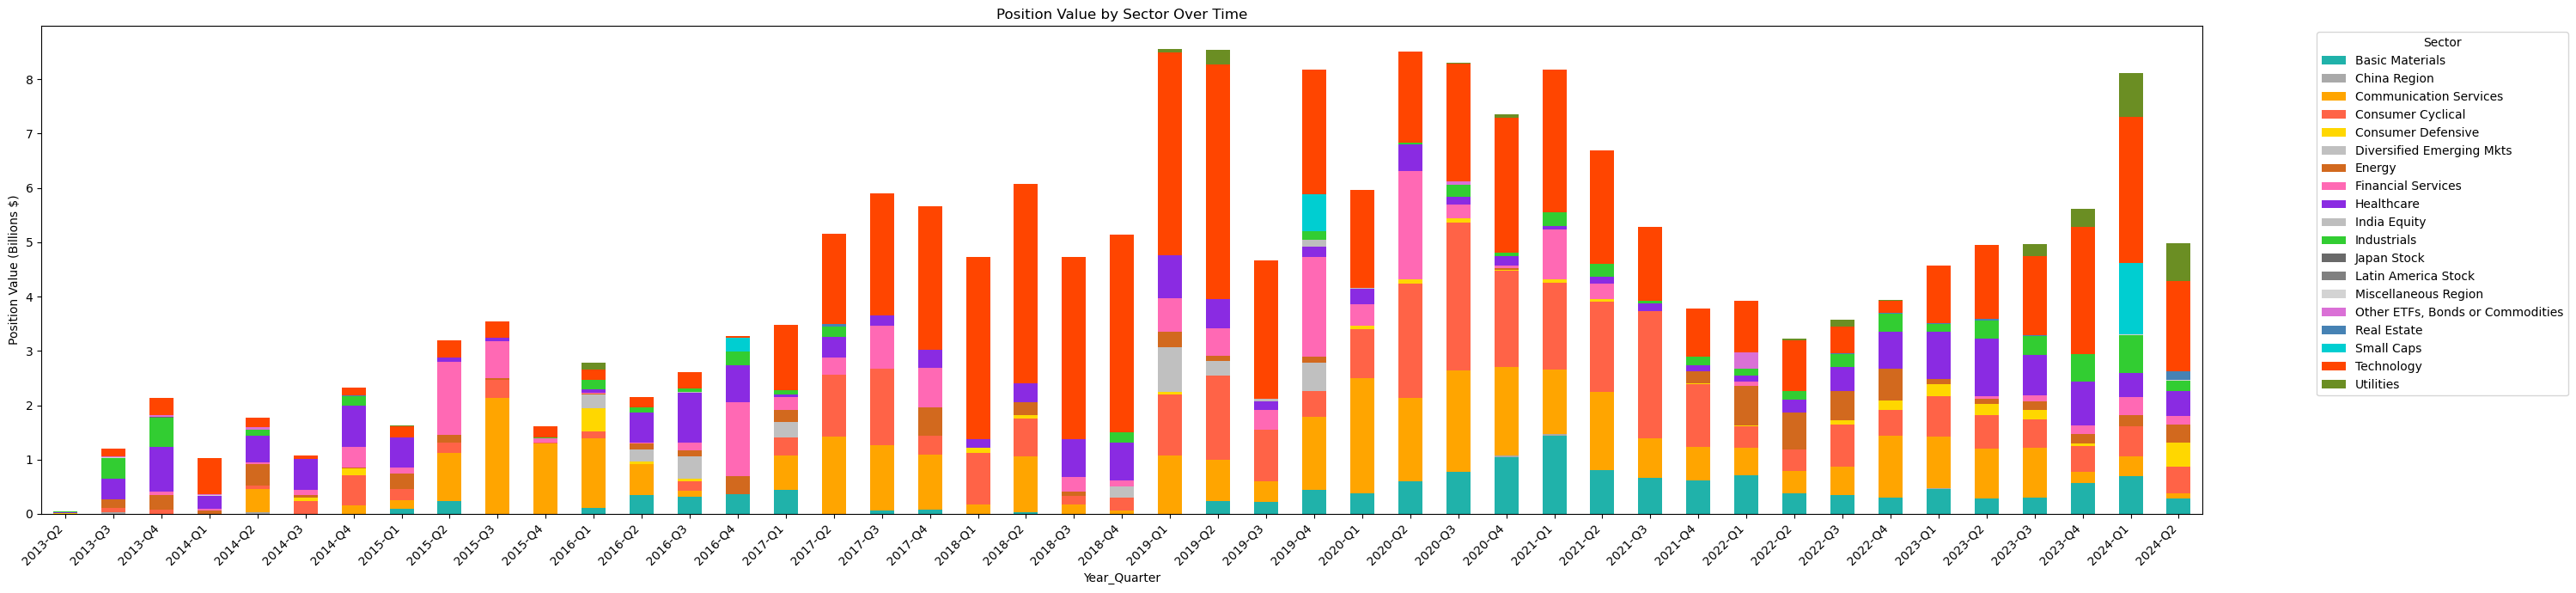

In [68]:
# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Stanley_Druckenmiller"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Position Value (Billions $)')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))


plt.tight_layout()
plt.show()

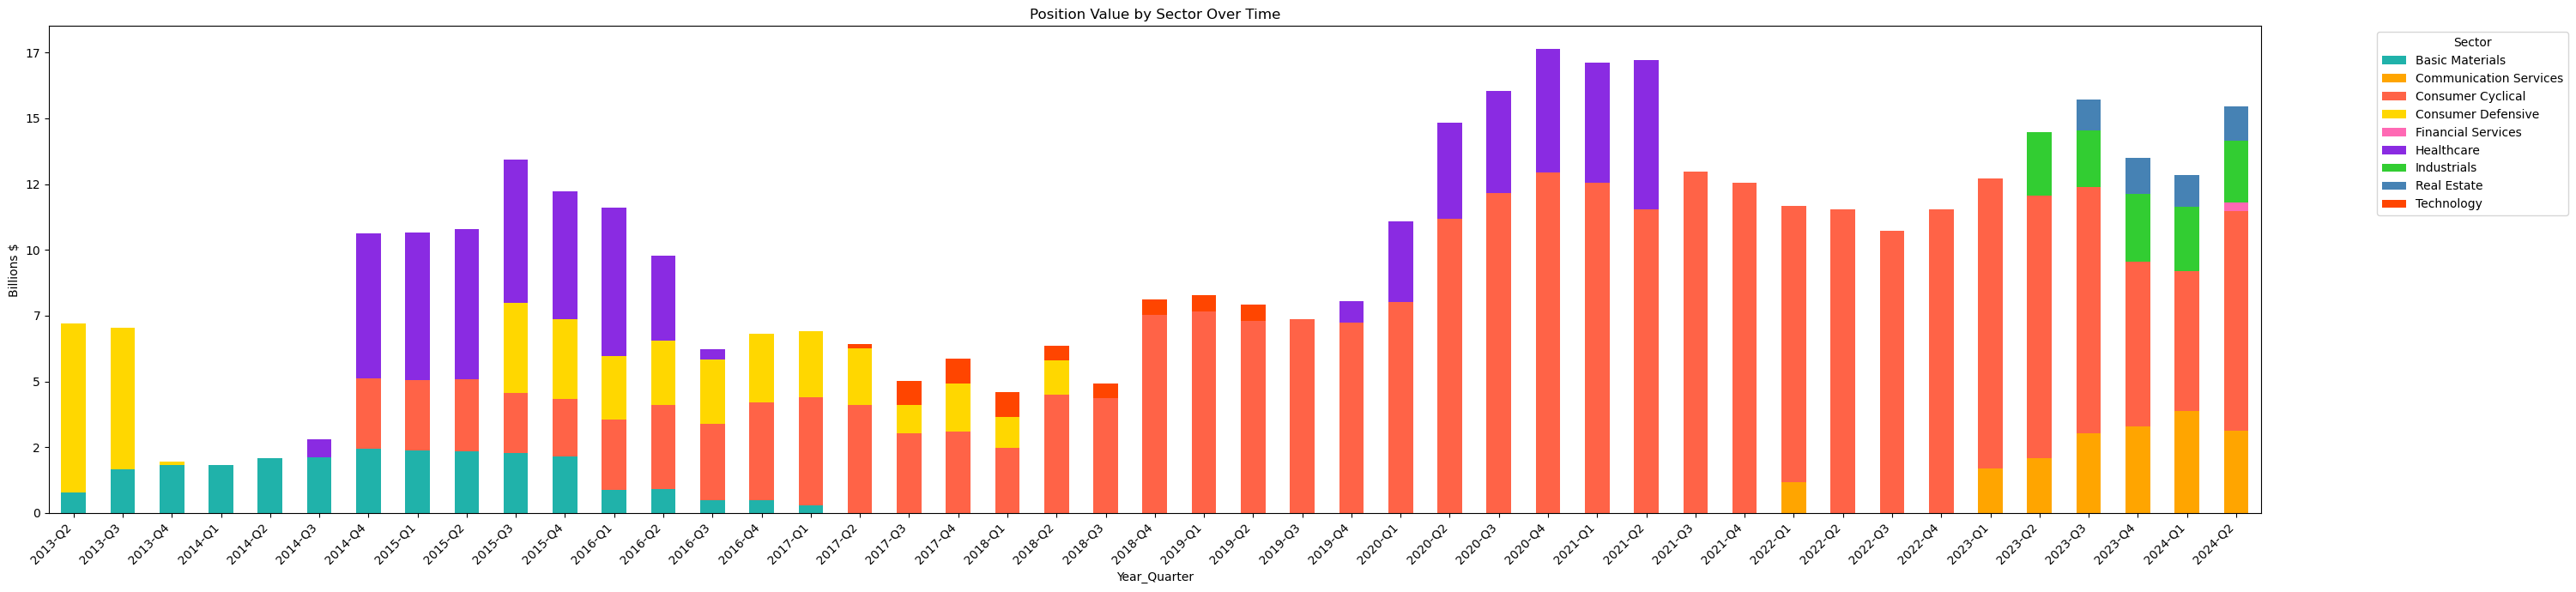

In [69]:
# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Bill_Ackman"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

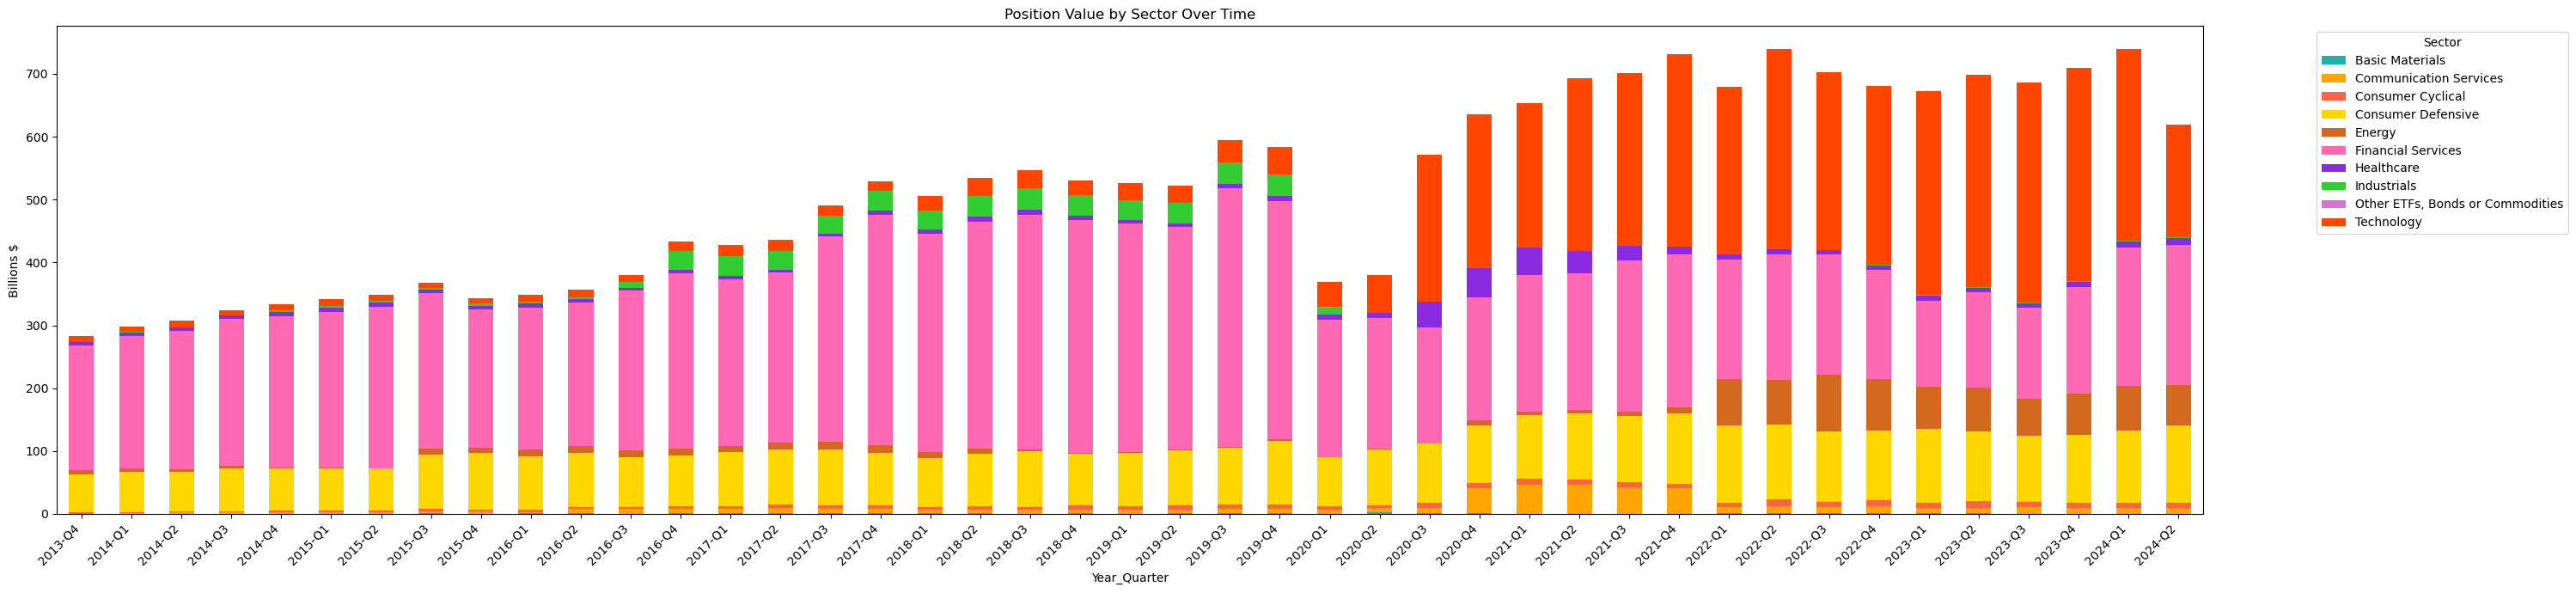

In [70]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Warren_Buffet"].groupby(["Year_Quarter", "Sector_Simp"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector_Simp', values='Position Value').fillna(0)

# Create a color map with distinct colors
# Create a color map with distinct colors
colors = [sector_colors.get(sector, 'gray') for sector in pivot_df.columns]

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

In [ ]:
ticker_data = yf.Ticker("AAPL")
dividends = ticker_data.dividends

# Print the dividend data
print(dividends)

Date
1987-05-11 00:00:00-04:00    0.000536
1987-08-10 00:00:00-04:00    0.000536
1987-11-17 00:00:00-05:00    0.000714
1988-02-12 00:00:00-05:00    0.000714
1988-05-16 00:00:00-04:00    0.000714
                               ...   
2023-08-11 00:00:00-04:00    0.240000
2023-11-10 00:00:00-05:00    0.240000
2024-02-09 00:00:00-05:00    0.240000
2024-05-10 00:00:00-04:00    0.250000
2024-08-12 00:00:00-04:00    0.250000
Name: Dividends, Length: 84, dtype: float64


In [ ]:
unique_symbols[unique_symbols["Sector"] == "Health"]

,NAME OF ISSUER,SYMBOL,Sector,Industry,Sector_Simp
127,ISHARES TR,IBB,Health,ETF,Healthcare
132,SELECT SECTOR SPDR TR,XLV,Health,ETF,Healthcare
133,SPDR SERIES TRUST,XBI,Health,ETF,Healthcare
227,Hlth Care Select Sctr SPDR,XLV,Health,ETF,Healthcare
300,Hlth Car Select Sctr SPDR Fnd,XLV,Health,ETF,Healthcare
359,Hlth Care Slct Sctr SPDR,XLV,Health,ETF,Healthcare
568,Spdr Ser Tr,XBI,Health,ETF,Healthcare
588,Ishares Tr,IBB,Health,ETF,Healthcare
